In [2]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

#from helper2 import generate_dataset, visualize_one_dataset, visualize_datasets, predict_grid, visualize_predictions
from torch.utils import data

%load_ext autoreload
%autoreload 2

import torchvision

from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

from sdlbfgs import *
from helpers_nn import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

### MNIST dataset
The MNIST dataset is loaded.

In [61]:
trainset = datasets.MNIST('', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [62]:
print("Training and test sets information is displayed.\n\n")
print("Trainset:\n",trainset)
print("Testset:\n",valset)

Training and test sets information is displayed.


Trainset:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Testset:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: PATH_TO_STORE_TESTSET
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [63]:
print(valloader)
len(valloader)

157

64 images in each batch and each image has a dimension of 28 x 28 pixels


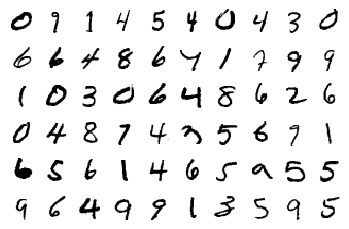

In [64]:
# A subset of a batch is plotted to show a sample of the dataset. 
dataiter = iter(trainloader)
images, labels = dataiter.next()
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Neural Network 

### Model definition
The model is defined, specifying the structure of the neural network.

### Model A: FCNN
Fully connected neural network, with hidden layer structure through vector *hidden_sizes*.

In [65]:
# Input and output sizes and network structure are defined.
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# The model is built
modelA=fully_connected_NN(sizes)
print(modelA)

# Loss of the model is defined.
criterion = nn.NLLLoss()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


### Model B: CNN
Convolutional neural network composed of two convolutional layers and two fully connected layers.

In [70]:
# The size of the images is computed.
images,_=dataiter.next()
image_size=images[0].shape[1]
# Using nn.CrossEntropyLoss allows to avoid specifying LogSoftmax as final layer.
criterion = nn.CrossEntropyLoss()
# Depending on the size of the image, a CNN model is built.
modelB=ConvNet(image_size)
print(modelB)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


### Training


ModelA is trained with SGD, used as baseline.

In [ ]:
lr=0.003
momentum=0.9
optimizer = optim.SGD(modelA.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 9

train_losses, test_losses,accuracies = optimize(optimizer, epochs, trainloader,valloader, modelA, criterion)

ModelB is trained with SGD, used as baseline.

In [71]:
lr=0.003
momentum=0.9
optimizer = optim.SGD(modelB.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 9

train_losses, test_losses,accuracies = optimize_CNN(optimizer, epochs, trainloader,valloader, modelB, criterion)

Epoch 0
Training loss: 0.37888462115317456
Number Of Images Tested = 10000
Model Accuracy = 0.9751


KeyboardInterrupt: 

In [ ]:
plt.plot(test_losses,label='Test loss')
plt.plot(train_losses,label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and test loss as function of the training epochs')
plt.legend()

In [ ]:
# This cell gives insight into how the prediction process works.
images, labels = next(iter(valloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Probabilities computed for each digit =\n",probab)
print("\nPredicted Digit =", probab.index(max(probab)))
print("Actual Digit =",labels[0].numpy())
#view_classify(img.view(1, 28, 28), ps)

In [ ]:
probabilities, predicctions = predict_one_img(valloader,model)

### Test
The trained model is used to predict the labels of the test set, and the model performance is evaluated.

In [ ]:
# Accuracy obtained for FCNN
accuracy = accuracy_test(valloader, model)

In [ ]:
# Accuracy obtained for CNN
accuracy=accuracy_test_CNN(valloader,modelB)

### Hyperparameter optimization

In [ ]:
epochs = 3
blr = best_learning_rate(input_size, output_size, trainloader, valloader)

## LBFGS

In [11]:
def LBFGS_optimizer(parameter):
    lr=0.8
    max_iter=4
    max_eval=None
    tolerance_grad=1e-5
    tolerance_change=1e-9
    history_size=10
    line_search_fn='strong_wolfe'
    return torch.optim.LBFGS(parameter, lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size, line_search_fn)

In [12]:
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# The model is built
modelA=fully_connected_NN(sizes)
# Loss of the model is defined.
criterion = nn.NLLLoss()

method = "LBFGS"
optimizer = LBFGS_optimizer(modelA.parameters())
time0 = time()
epochs = 9

train_losses, test_losses = optimize(optimizer, epochs, trainloader,valloader, modelA, criterion, method)

Epoch 0
Training loss: 0.2336213135643046
Number Of Images Tested = 10000
Model Accuracy = 0.8757
Test loss: 0.47416786944410605 

Epoch 1
Training loss: 0.10076390888215775
Number Of Images Tested = 10000
Model Accuracy = 0.9302
Test loss: 0.2901369624646606 

Epoch 2
Training loss: 0.07130079689394209
Number Of Images Tested = 10000
Model Accuracy = 0.9121
Test loss: 0.3302885894752612 

Epoch 3
Training loss: 0.06267887659496622
Number Of Images Tested = 10000
Model Accuracy = 0.8781
Test loss: 0.7061136340259746 

Epoch 4
Training loss: 0.06015837944858558
Number Of Images Tested = 10000
Model Accuracy = 0.9366
Test loss: 0.2789079921741252 

Epoch 5
Training loss: 0.05284824906086335
Number Of Images Tested = 10000
Model Accuracy = 0.956
Test loss: 0.2104364342640516 

Epoch 6
Training loss: 0.04910113841904251
Number Of Images Tested = 10000
Model Accuracy = 0.9409
Test loss: 0.25117478637131535 

Epoch 7
Training loss: 0.04357602489615404
Number Of Images Tested = 10000
Model Ac

## LBFGS

In [13]:
from lbfgsnew import LBFGSNew

In [14]:
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# The model is built
modelA=fully_connected_NN(sizes)
# Loss of the model is defined.
criterion = nn.NLLLoss()

method = "LBFGS"
optimizer = LBFGSNew(modelA.parameters(), history_size=10, max_iter=4, line_search_fn=True,batch_mode=True)
time0 = time()
epochs = 9

train_losses, test_losses = optimize(optimizer, epochs, trainloader,valloader, modelA, criterion, method)

Epoch 0
Training loss: 0.1814858174499577
Number Of Images Tested = 10000
Model Accuracy = 0.9164
Test loss: 0.2739972212606934 

Epoch 1
Training loss: 0.028902051231659044
Number Of Images Tested = 10000
Model Accuracy = 0.9536
Test loss: 0.15351262607961702 

Epoch 2
Training loss: 0.012469801827639675
Number Of Images Tested = 10000
Model Accuracy = 0.9523
Test loss: 0.15348484793049136 

Epoch 3
Training loss: 0.007397422348576059
Number Of Images Tested = 10000
Model Accuracy = 0.9678
Test loss: 0.12214583658337427 

Epoch 4
Training loss: 0.004867846431617222
Number Of Images Tested = 10000
Model Accuracy = 0.9675
Test loss: 0.11971487159541197 

Epoch 5
Training loss: 0.0037149672961430446
Number Of Images Tested = 10000
Model Accuracy = 0.9718
Test loss: 0.11266962830259043 

Epoch 6
Training loss: 0.0029605305457490435
Number Of Images Tested = 10000
Model Accuracy = 0.9151
Test loss: 0.3568609409230008 

Epoch 7
Training loss: 0.0024198842181883473
Number Of Images Tested = 

## SdLBFGS

### Fully connected network

In [53]:
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# The model is built
modelA=fully_connected_NN(sizes)
# Loss of the model is defined.
criterion = nn.NLLLoss()

method = "SdLBFGS"
optimizer = SdLBFGS(modelA.parameters(), lr = 0.1,  lr_decay=False)

epochs = 15

train_losses, test_losses = optimize(optimizer, epochs, trainloader,valloader, modelA, criterion, method)

Epoch 0
Training loss: 0.4039235459819341
Number Of Images Tested = 10000
Model Accuracy = 0.9229
Test loss: 0.2626497335969263 

Epoch 1
Training loss: 0.23561435670399272
Number Of Images Tested = 10000
Model Accuracy = 0.9327
Test loss: 0.23508894787567436 

Epoch 2
Training loss: 0.21086871653481493
Number Of Images Tested = 10000
Model Accuracy = 0.9321
Test loss: 0.26585062670337545 

Epoch 3
Training loss: 0.20712342052591412
Number Of Images Tested = 10000
Model Accuracy = 0.9438
Test loss: 0.20462967442929936 

Epoch 4
Training loss: 0.19482349408125238
Number Of Images Tested = 10000
Model Accuracy = 0.9407
Test loss: 0.2238483640845794 

Epoch 5
Training loss: 0.2067316882937813
Number Of Images Tested = 10000
Model Accuracy = 0.9434
Test loss: 0.228798810514224 

Epoch 6
Training loss: 0.18486688917823957
Number Of Images Tested = 10000
Model Accuracy = 0.9418
Test loss: 0.24560134396384095 

Epoch 7
Training loss: 0.2135200366945138
Number Of Images Tested = 10000
Model Ac

### CNN

In [ ]:
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# Model building
# The size of the images is computed.
images,_=dataiter.next()
image_size=images[0].shape[1]
# Using nn.CrossEntropyLoss allows to avoid specifying LogSoftmax as final layer.
criterion = nn.CrossEntropyLoss()
modelB=ConvNet(image_size)


method = "SdLBFGS"
optimizer = SdLBFGS(modelB.parameters(), lr = 0.1,  lr_decay=False, history_size= 50)

epochs = 5

train_losses, test_losses,accuracies = optimize_CNN(optimizer, epochs, trainloader,valloader, modelB, criterion, method)